## Homography

<p style='direction:rtl; text-align: right'>
برای محاسبه هوموگرافی بین دو تصویر،‌ابتدا با استفاده روش SIFT تعدادی Interest point با دیسکریپتور به دست می‌آوریم. سپس
برای مچ کردن آن‌ها، از روشی مشابه سوال اول استفاده می‌کنیم که ابتدا به ازای هر نقطه، دو تا از نزدیک‌ترین مچ‌ها را پیدا کنیم
و سپس در صورتی که زیاد به هم نزدیک نزدیک نبودند، بهترین مچ را به عنوان مچ آن نقطه در نظر می‌گیریم.
<br>
در نهایت با استفاده از روش RanSaC از بین مچ‌ها تعدادی inlier برای مدل هوموگرافی به دست می‌آوریم و در نهایت روی این نقاط،‌
روش Least Squares را اجرا می‌کنیم تا یک ماتریس هوموگرافی به دست آید که با استفاده از آن، تصویر را warp خواهیم کرد.
</p>


<p style='direction:rtl; text-align: right'>
ایمپورت های لازم را انجام می‌دهیم و تصاویر را از فایل خوانده و نمایش می‌دهیم:
</p>


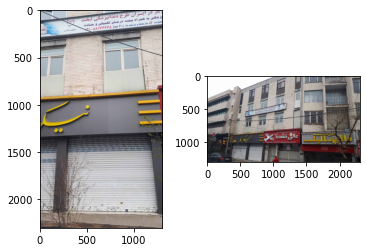

In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt


def imshow(*srcs):
    plt.close()
    fig, ax = plt.subplots(ncols=len(srcs))
    for i, src in enumerate(srcs):
        t = (src - src.min()) / (src.max() - src.min())
        if (len(srcs)) > 1:
            ax[i].imshow(t, cmap='gray')
        else:
            ax.imshow(t, cmap='gray')
    plt.show()


img1 = plt.imread('./data/hw1/im03.jpg')
img2 = plt.imread('./data/hw1/im04.jpg')

imshow(img1, img2)

<p style='direction:rtl; text-align: right'>
حال با روش SIFT تعدادی نقطه به دست می‌آوریم:
</p>


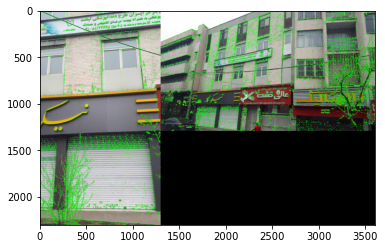

In [2]:
sift = cv.SIFT_create()

kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

img_corners = cv.drawMatches(img1, kp1, img2, kp2, None, None, singlePointColor=(0, 255, 0))
imshow(img_corners)

<p style='direction:rtl; text-align: right'>
نقاط را همانطور که گفته شد، با نسبت خطای 0.7 مچ می‌کنیم:
</p>


In [3]:
match_ratio_threshold = 0.7
matches = cv.BFMatcher().knnMatch(des1, des2, k=2)
matches = [m1 for m1, m2 in matches if m1.distance < match_ratio_threshold * m2.distance]


<p style='direction:rtl; text-align: right'>
نقاط متناظر انتخاب شده با رنگ آبی:
</p>


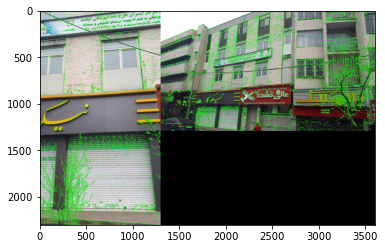

In [4]:
img_correspondence = img_corners.copy()
for match in matches:
    cv.drawMatches(img1, [kp1[match.queryIdx]], img2, [kp2[match.trainIdx]], None, img_correspondence
                   , singlePointColor=(0, 0, 255), flags=cv.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)
imshow(img_correspondence)


<p style='direction:rtl; text-align: right'>
نمایش خطوط بین نقاط مچ شده:
</p>


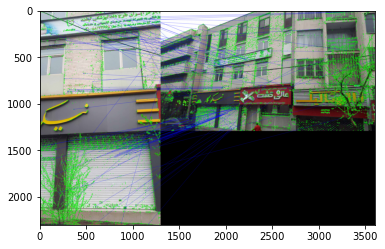

In [5]:
img_matches = img_correspondence.copy()
cv.drawMatches(img1, kp1, img2, kp2, matches, img_matches
               , matchColor=(0, 0, 255),
               flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS + cv.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)
imshow(img_matches)

<p style='direction:rtl; text-align: right'>
نمایش ۲۰ تا از بعضی مچ‌ها:
</p>


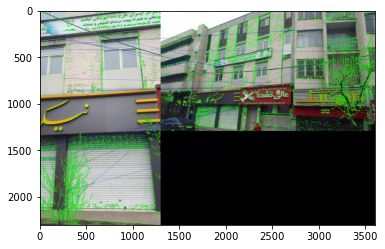

In [6]:
img_matches_some = img_correspondence.copy()
cv.drawMatches(img1, kp1, img2, kp2, matches[:20], img_matches_some
               , matchColor=(0, 0, 255),
               flags=cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS + cv.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG)
imshow(img_matches_some)

<p style='direction:rtl; text-align: right'>
حال روش RanSaC را با حداکثر تکرار ۵۰۰۰، خطای inlier به اندازه ۵ پیکسل و توقف با ضریب اطمینان ۰.۹۹۵ اجرا می‌کنیم:
</p>


In [7]:
img1_final_points = np.float32([kp1[m.queryIdx].pt for m in matches])
img2_final_points = np.float32([kp2[m.trainIdx].pt for m in matches])

M, mask = cv.findHomography(img2_final_points, img1_final_points, cv.RANSAC,
                            ransacReprojThreshold=5,
                            maxIters=5000,
                            confidence=0.995)

<p style='direction:rtl; text-align: right'>
اینلایر ها را با خطوط قرمز نمایش می‌دهیم:
</p>


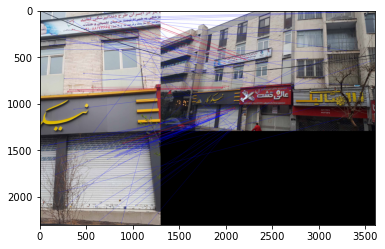

In [8]:
img_inliers = cv.drawMatches(img1, None, img2, None, None, None)
cv.drawMatches(img1, kp1, img2, kp2, matches, img_inliers
               , matchColor=(0, 0, 255), singlePointColor=(0, 0, 255),
               flags=cv.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG + cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
cv.drawMatches(img1, kp1, img2, kp2, matches, img_inliers, matchColor=(255, 0, 0), singlePointColor=(255, 0, 0),
               matchesMask=mask,
               flags=cv.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG + cv.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
imshow(img_inliers)

<p style='direction:rtl; text-align: right'>
و در نهایت تصویر را وارپ می‌کنیم و در قاب تصویر اول نمایش می‌دهیم.
</p>


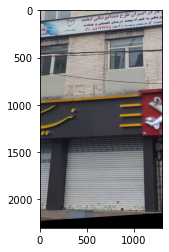

In [9]:
img2_warped = cv.warpPerspective(img2, M, img1.shape[:2][::-1])
imshow(img2_warped)

